In [1]:
import math
import numpy as np
from datetime import datetime, timedelta, date
import time
import xarray as xr
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
def speedstats(dsspeed, percent=False):
    bins=list(range(0,int(dsspeed["speed"].max())+2))
    sg = dsspeed.groupby_bins("speed",bins)
    speedcounts = sg.count(...)["speed"]
    speedlabelsdict={}
    for k in sg.groups:
        speedlabelsdict[k.left]=k
    speedlabels=[]    
    for k in sorted(speedlabelsdict):
        speedlabels.append("%s"%speedlabelsdict[k])
    if percent:
        alldscount = dsspeed["speed"].count().item(0)
        speedcounts = speedcounts/alldscount
    return speedlabels, speedcounts

In [3]:
def directionstats(dsdir, percent=False):
    dirlabels = ["N","NE", "E", "SE", "S", "SW", "W", "NW"]
    dirgroup = dsdir.groupby("direction")
    dircounts = dirgroup.count(...)["angle"]
    if percent:
        alldscount = dsdir["speed"].count().item(0)
        dircounts = dircounts/alldscount
    return dirlabels, dircounts

In [4]:
ds = xr.load_dataset("/home/aapostolakis/Documents/preprocess/1990_2020_speed_dir.nc")

In [5]:
ds

<xarray.Dataset>
Dimensions:     (latitude: 3, longitude: 2, step: 24, time: 6512)
Coordinates:
    valid_time  (time, step) datetime64[ns] 1990-03-31T01:00:00 ... 2020-06-01
  * time        (time) datetime64[ns] 1990-03-31 1990-04-01 ... 2020-05-31
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
  * latitude    (latitude) float64 38.0 37.9 37.8
  * longitude   (longitude) float64 23.9 24.0
    number      int32 0
    surface     int32 0
Data variables:
    u10         (time, step, latitude, longitude) float32 nan nan ... 1.0295258
    v10         (time, step, latitude, longitude) float32 nan nan ... 0.37730408
    speed       (time, step, latitude, longitude) float32 nan nan ... 1.0964861
    angle       (time, step, latitude, longitude) float64 nan nan ... nan 249.9
    direction   (time, step, latitude, longitude) float64 nan nan ... nan 7.0
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-10-13T17:53:06 GRIB to CDM+CF via cfgrib-0....

In [6]:
dscell = ds.sel(latitude=slice(37.95,37.85), longitude=slice(23.85, 23.95))
dscell

<xarray.Dataset>
Dimensions:     (latitude: 1, longitude: 1, step: 24, time: 6512)
Coordinates:
    valid_time  (time, step) datetime64[ns] 1990-03-31T01:00:00 ... 2020-06-01
  * time        (time) datetime64[ns] 1990-03-31 1990-04-01 ... 2020-05-31
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
  * latitude    (latitude) float64 37.9
  * longitude   (longitude) float64 23.9
    number      int32 0
    surface     int32 0
Data variables:
    u10         (time, step, latitude, longitude) float32 nan nan ... 1.0353851
    v10         (time, step, latitude, longitude) float32 nan nan ... 0.37730408
    speed       (time, step, latitude, longitude) float32 nan nan ... 1.1019894
    angle       (time, step, latitude, longitude) float64 nan nan ... 250.0
    direction   (time, step, latitude, longitude) float64 nan nan ... 6.0 7.0
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-10-13T17:53:06 GRIB to CDM+CF via cfgrib-0....

<BarContainer object of 12 artists>

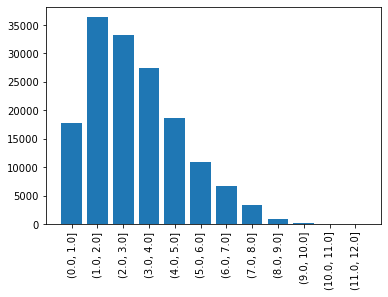

In [7]:
lab, speeds = speedstats(dscell)
plt.xticks(rotation=90)
plt.bar(lab,speeds)

<BarContainer object of 8 artists>

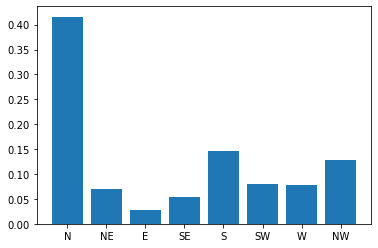

In [8]:
directions,dircounts = directionstats(dscell, percent=True)
plt.bar(directions,dircounts)

In [10]:
dircounts

<xarray.DataArray 'angle' (direction: 8)>
array([0.41593751, 0.06923398, 0.02713041, 0.05329647, 0.1463435 ,
       0.08027259, 0.07890964, 0.12887589])
Coordinates:
  * direction  (direction) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
    number     int32 0
    surface    int32 0

In [12]:
start="2010-01-01"
end="2020-12-31"
dstimerange=dscell.sel(time=slice(start, end))

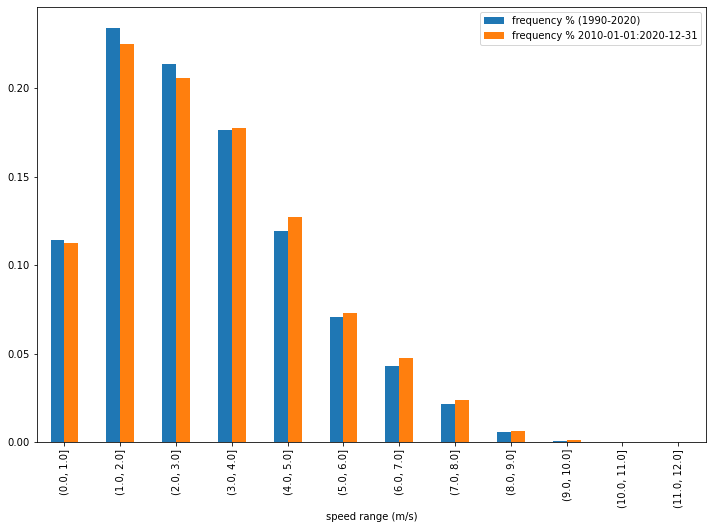

In [13]:
lab1, speeds1 = speedstats(dscell, percent=True)
lab2, speeds2 = speedstats(dstimerange, percent=True)
speeds2 = np.append(speeds2, np.zeros(len(speeds1)-len(speeds2), dtype=np.int8))
dfplt=pd.DataFrame({"speed range (m/s)":lab1, "frequency % (1990-2020)":speeds1, "frequency %% %s:%s"%(start,end):speeds2})
dfplt.plot.bar(x='speed range (m/s)',  figsize=(12,8), logy=False)

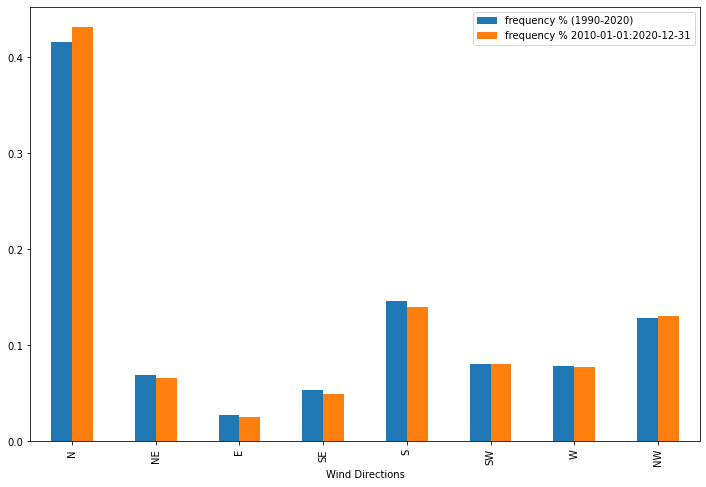

In [17]:
lab1, dirs1 = directionstats(dscell, percent=True)
lab2, dirs2 = directionstats(dstimerange, percent=True)
dfplt=pd.DataFrame({"Wind Directions":lab1, "frequency % (1990-2020)":dirs1, "frequency %% %s:%s"%(start,end):dirs2, })
dfplt.plot.bar(x="Wind Directions", figsize=(12,8))

In [16]:
dstimerange

<xarray.Dataset>
Dimensions:     (latitude: 1, longitude: 1, step: 24, time: 2212)
Coordinates:
    valid_time  (time, step) datetime64[ns] 2010-03-31T01:00:00 ... 2020-06-01
  * time        (time) datetime64[ns] 2010-03-31 2010-04-01 ... 2020-05-31
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
  * latitude    (latitude) float64 37.9
  * longitude   (longitude) float64 23.9
    number      int32 0
    surface     int32 0
Data variables:
    u10         (time, step, latitude, longitude) float32 nan nan ... 1.0353851
    v10         (time, step, latitude, longitude) float32 nan nan ... 0.37730408
    speed       (time, step, latitude, longitude) float32 nan nan ... 1.1019894
    angle       (time, step, latitude, longitude) float64 nan nan ... 250.0
    direction   (time, step, latitude, longitude) float64 nan nan ... 6.0 7.0
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-10-13T17:53:06 GRIB to CDM+CF via cfgrib-0....